# EDA Demografía

Este cuaderno explora los indicadores demográficos enriquecidos en `fact_demografia`.

## Objetivos
- Validar la consistencia de los campos completados durante el ETL.
- Analizar tendencias por barrio y año.
- Identificar valores atípicos o vacíos restantes que requieran atención.



In [1]:
from pathlib import Path
import sqlite3

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parent
DB_PATH = PROJECT_ROOT / "data" / "processed" / "database.db"

pd.set_option("display.float_format", lambda v: f"{v:,.2f}")
pd.set_option("display.max_columns", 30)

sns.set_theme(style="whitegrid")
print(f"Usando base de datos: {DB_PATH}")


Usando base de datos: /Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/data/processed/database.db


In [2]:
def load_table(table_name: str) -> pd.DataFrame:
    """Carga una tabla SQLite en un DataFrame."""
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    print(f"{table_name}: {len(df):,} filas")
    return df


dim_barrios = load_table("dim_barrios")
fact_demografia = load_table("fact_demografia")


dim_barrios: 73 filas
fact_demografia: 657 filas


In [3]:
fact_demografia.head()


,id,barrio_id,anio,poblacion_total,poblacion_hombres,poblacion_mujeres,hogares_totales,edad_media,porc_inmigracion,densidad_hab_km2,dataset_id,source,etl_loaded_at
0,3286,1,2015,47150,21430,25720,20695,120.42,6.14,"63,834.91",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575
1,3287,2,2015,15514,7363,8151,6809,129.46,3.97,"33,226.96",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575
2,3288,3,2015,15037,7537,7500,6600,94.01,4.28,"36,297.67",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575
3,3289,4,2015,22468,11238,11230,9862,121.60,5.76,"26,435.30",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575
4,3290,5,2015,31548,16723,14825,13785,69.62,2.20,"53,456.96",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575


In [4]:
metrics = [
    "poblacion_total",
    "hogares_totales",
    "edad_media",
    "porc_inmigracion",
    "densidad_hab_km2",
]
fact_demografia[metrics].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])


,poblacion_total,hogares_totales,edad_media,porc_inmigracion,densidad_hab_km2
count,657.00,657.00,657.00,637.00,657.00
mean,"22,445.69","10,525.90",66.83,0.82,"37,920.63"
std,"14,560.99","7,536.66",17.28,1.22,"22,721.81"
min,542.00,233.00,32.52,0.00,181.20
5%,"2,273.80","1,036.40",44.08,0.00,"4,816.81"
25%,"10,513.00","5,004.00",55.98,0.09,"18,984.46"
50%,"21,319.00","9,823.00",63.16,0.38,"34,781.86"
75%,"31,087.00","14,499.00",70.44,0.88,"53,456.96"
95%,"50,425.00","24,088.00",94.63,3.57,"78,505.13"
max,"58,668.00","46,877.00",129.46,7.16,"87,830.73"


In [5]:
fact_demografia[metrics].isna().sum().to_frame(name="nulls")


,nulls
poblacion_total,0
hogares_totales,0
edad_media,0
porc_inmigracion,20
densidad_hab_km2,0


In [6]:
porc_missing = fact_demografia[fact_demografia["porc_inmigracion"].isna()]
porc_missing = porc_missing.merge(dim_barrios[["barrio_id", "barrio_nombre", "distrito_nombre"]], on="barrio_id", how="left")
porc_missing[["anio", "barrio_id", "barrio_nombre", "distrito_nombre", "dataset_id", "source"]].head()


,anio,barrio_id,barrio_nombre,distrito_nombre,dataset_id,source
0,2015,11,el Poble-sec,Sants-Montjuïc,pad_mdbas_sexe|hd7u1b68qj|ydtnyd6qhm|wjnmk82jd9,opendatabcn|portaldades
1,2015,12,la Marina del Prat Vermell,Sants-Montjuïc,pad_mdbas_sexe|hd7u1b68qj|ydtnyd6qhm|wjnmk82jd9,opendatabcn|portaldades
2,2015,47,Can Peguera,Nou Barris,pad_mdbas_sexe|hd7u1b68qj|ydtnyd6qhm|wjnmk82jd9,opendatabcn|portaldades
3,2016,11,el Poble-sec,Sants-Montjuïc,pad_mdbas_sexe|hd7u1b68qj|ydtnyd6qhm|wjnmk82jd9,opendatabcn|portaldades
4,2016,12,la Marina del Prat Vermell,Sants-Montjuïc,pad_mdbas_sexe|hd7u1b68qj|ydtnyd6qhm|wjnmk82jd9,opendatabcn|portaldades


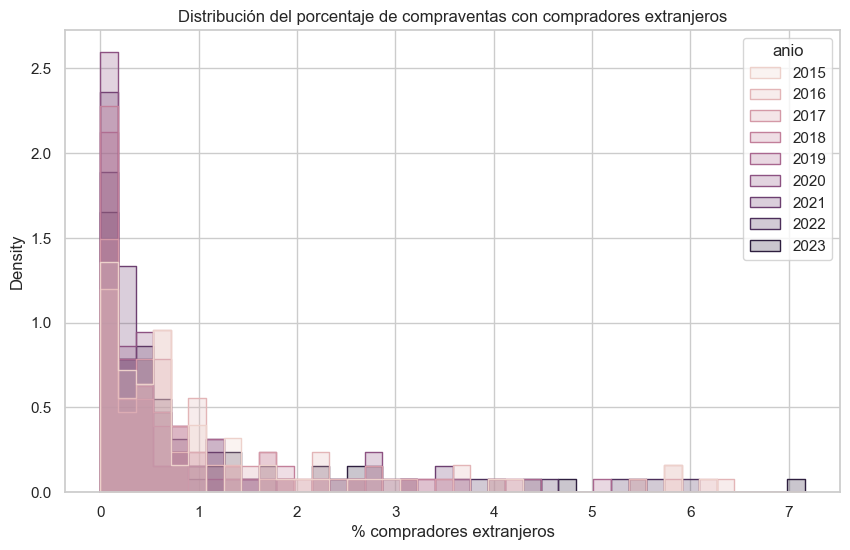

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=fact_demografia,
    x="porc_inmigracion",
    hue="anio",
    bins=40,
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Distribución del porcentaje de compraventas con compradores extranjeros")
plt.xlabel("% compradores extranjeros")
plt.show()


In [8]:
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=demografia_latest,
    x="densidad_hab_km2",
    y="hogares_totales",
    hue="distrito_nombre",
    palette="tab10",
    alpha=0.8,
)
plt.xscale("log")
plt.yscale("log")
plt.title("Hogares vs Densidad (último año disponible por barrio)")
plt.xlabel("Densidad hab/km² (log)")
plt.ylabel("Hogares totales (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


NameError: name 'demografia_latest' is not defined

<Figure size 900x600 with 0 Axes>

In [ ]:
evolucion_distrito = (
    fact_demografia.groupby(["anio", "barrio_id"])["poblacion_total"].sum().reset_index()
    .merge(dim_barrios[["barrio_id", "distrito_nombre"]], on="barrio_id", how="left")
    .groupby(["anio", "distrito_nombre"], as_index=False)["poblacion_total"].sum()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=evolucion_distrito,
    x="anio",
    y="poblacion_total",
    hue="distrito_nombre",
    marker="o"
)
plt.title("Evolución de población por distrito")
plt.ylabel("Población total")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [ ]:
corr = demografia_latest[metrics].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="RdBu", center=0)
plt.title("Correlaciones entre métricas demográficas (último año por barrio)")
plt.show()


## Observaciones preliminares

- Completar tras ejecutar celdas: anotar barrios con `porc_inmigracion` faltante y revisar si la fuente lo soporta.
- Evaluar si la densidad extrema corresponde a distritos centralizados o ruido en superficie.
- Considerar integrar indicadores adicionales (edad media de habitantes, renta, etc.) para contextualizar tendencias.



In [ ]:
(fact_demografia
 .groupby("anio")[metrics]
 .agg(["mean", "median", "min", "max"])
 .round(2))


poblacion_total                       hogares_totales                 \
                mean    median  min    max            mean    median  min   
anio                                                                        
2015       21,982.19 20,163.00  542  57664        9,437.55  8,560.00  233   
2016       22,060.64 20,381.00  590  57699        9,471.22  8,653.00  253   
2017       22,262.15 20,519.00  611  58337        9,557.77  8,711.00  262   
2018       22,314.19 20,628.00  657  58265        9,579.75  8,758.00  282   
2019       22,607.64 21,116.00  686  58668        9,706.12  8,965.00  295   
2020       22,829.18 21,715.00  709  58648        9,801.36  9,524.00  305   
2021       22,744.03 22,299.00  698  58225       17,769.08 17,507.00  543   
2022       22,465.49 21,947.00  669  57605        9,645.21  9,308.00  287   
2023       22,745.68 22,041.00  699  57902        9,765.03  9,357.00  300   

            edad_media                     porc_inmigracion                   \
        max       mean median   min    max             mean median  min  max   
anio                                                                           
2015  25196      66.83  63.16 32.52 129.46             1.00   0.55 0.00 6.14   
2016  25211      66.83  63.16 32.52 129.46             1.09   0.61 0.00 6.30   
2017  25490      66.83  63.16 32.52 129.46             1.02   0.54 0.00 6.21   
2018  25459      66.83  63.16 32.52 129.46             0.72   0.28 0.00 3.95   
2019  25635      66.83  63.16 32.52 129.46             0.76   0.35 0.00 5.09   
2020  25626      66.83  63.16 32.52 129.46             0.48   0.24 0.00 3.68   
2021  46877      66.83  63.16 32.52 129.46             0.53   0.23 0.00 3.70   
2022  25043      66.83  63.16 32.52 129.46             0.86   0.40 0.00 6.08   
2023  25161      66.83  63.16 32.52 129.46             0.96   0.41 0.00 7.16   

     densidad_hab_km2                             
                 mean    median    min       max  
anio                                              
2015        37,100.36 34,535.10 181.20 85,910.40  
2016        37,211.56 34,231.50 185.08 86,422.75  
2017        37,543.64 34,781.86 185.89 86,712.17  
2018        37,666.17 35,950.07 187.50 86,665.23  
2019        38,203.15 36,625.96 193.64 87,134.56  
2020        38,618.15 36,478.71 198.16 87,830.73  
2021        38,494.06 36,510.09 218.99 87,212.78  
2022        37,983.39 34,620.02 245.00 85,836.09  
2023        38,465.21 35,498.43 271.00 86,293.68

In [ ]:
demografia_latest = fact_demografia.sort_values("anio").groupby("barrio_id").tail(1)
demografia_latest = demografia_latest.merge(
    dim_barrios[["barrio_id", "barrio_nombre", "distrito_nombre"]],
    on="barrio_id",
    how="left",
)
demografia_latest.head()


,id,barrio_id,anio,poblacion_total,poblacion_hombres,poblacion_mujeres,hogares_totales,edad_media,porc_inmigracion,densidad_hab_km2,dataset_id,source,etl_loaded_at,barrio_nombre,distrito_nombre
0,3917,48,2023,15265,8203,7062,6471,54.85,0.00,"31,855.97",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575,la Guineueta,Nou Barris
1,3921,52,2023,26664,14185,12479,11304,56.79,0.41,"70,800.41",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575,la Prosperitat,Nou Barris
2,3920,51,2023,12774,6865,5909,5415,55.80,0.09,"79,611.11",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575,Verdun,Nou Barris
3,3919,50,2023,16523,8567,7956,7005,55.43,0.25,"54,686.75",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575,les Roquetes,Nou Barris
4,3918,49,2023,6786,3588,3198,2877,51.39,0.00,"29,020.46",pad_mdbas_sexe|hd7u1b68qj|uuxbxa7onv|ydtnyd6qh...,opendatabcn|portaldades,2025-11-13T14:47:46.276575,Canyelles,Nou Barris


## Ideas de visualización

- Distribución de `porc_inmigracion` por barrio y año.
- Relación entre `densidad_hab_km2` y `hogares_totales`.
- Evolución temporal de `poblacion_total` por distrito.

